# Decision Trees

In this notebook we discuss algorithms based on decision trees.
Let's first look at an example of how a decision tree solves a regression problem in contrast to linear regression.

We will use the `penguins` dataset that you can find on grips.

In [1]:
import pandas as pd

penguins = pd.read_csv("penguins_regression.csv")
penguins.head()

,Flipper Length (mm),Body Mass (g)
0,181.0,3750.0
1,186.0,3800.0
2,195.0,3250.0
3,193.0,3450.0
4,190.0,3650.0


We use this dataset to create a regression problem where we want to predict the body mass of a penguin based on its flipper length.

In [2]:
feature_name = "Flipper Length (mm)"
target_name = "Body Mass (g)"
data_train, target_train = penguins[[feature_name]], penguins[[target_name]]

Let's plot the data, our goal here is to understand how a decision tree regressor works.

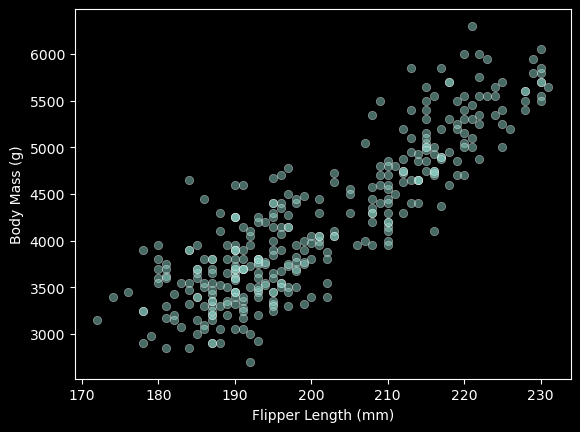

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

_ = sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, alpha=0.5
)


Now let's look at the difference between a linear regression and a decision tree.

In [4]:
import numpy as np

data_test = pd.DataFrame(
    np.arange(data_train[feature_name].min(), data_train[feature_name].max()),
             columns=[feature_name]
)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(data_train, target_train)
target_predicted = lr.predict(data_test)

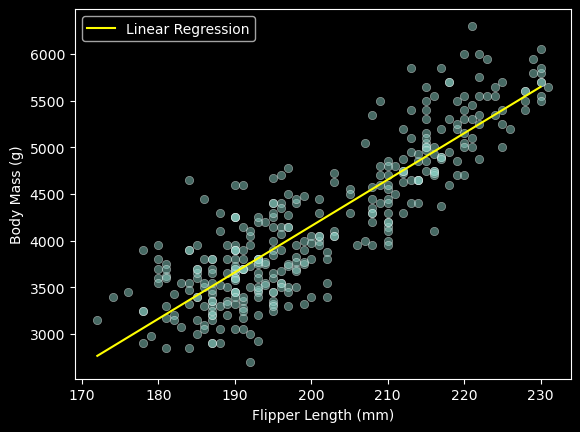

In [5]:
sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, alpha=0.5
)
plt.plot(data_test[feature_name], target_predicted, color="yellow", label= "Linear Regression")
_ = plt.legend()

The idea of a decision tree is essentially to ask a hierarchy of if-else questions.
To illustrate, let's look at a decision tree of depth 1.

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=1)
tree.fit(data_train, target_train)
target_predicted = tree.predict(data_test)

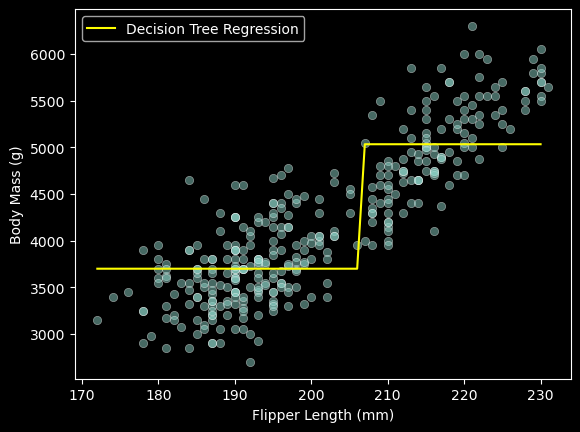

In [7]:
sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, alpha=0.5
)
plt.plot(data_test[feature_name], target_predicted, color="yellow", 
         label= "Decision Tree Regression")
_ = plt.legend()

Basically, the tree divides the training set according to some threshold, in this case it takes the flipper length around 206 mm.
Then it predicts the mean for all points below the threshold and above the threshold.

We can actually check the form of the tree by calling the `plot_tree` function.

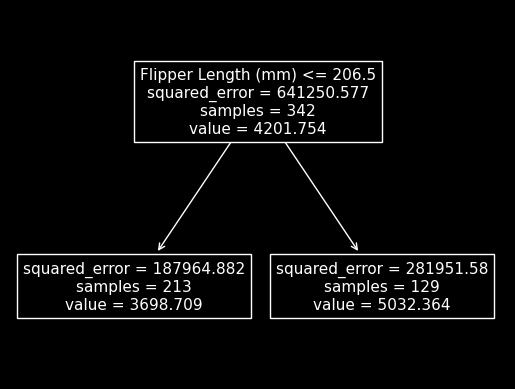

In [8]:
from sklearn.tree import plot_tree

_ = plot_tree(tree, feature_names=[feature_name])

Clearly, the depth of a tree is a hyperparameter.
Let's see how the regression function looks like when increasing the depth size.

In [9]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(data_train, target_train)
target_predicted = tree.predict(data_test)

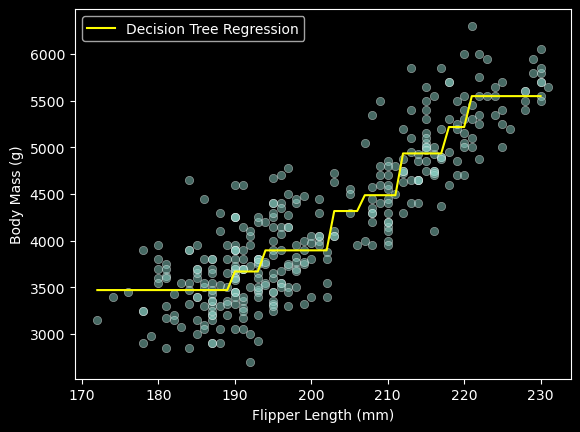

In [10]:
sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, alpha=0.5
)
plt.plot(data_test[feature_name], target_predicted, color="yellow", 
         label= "Decision Tree Regression")
_ = plt.legend()

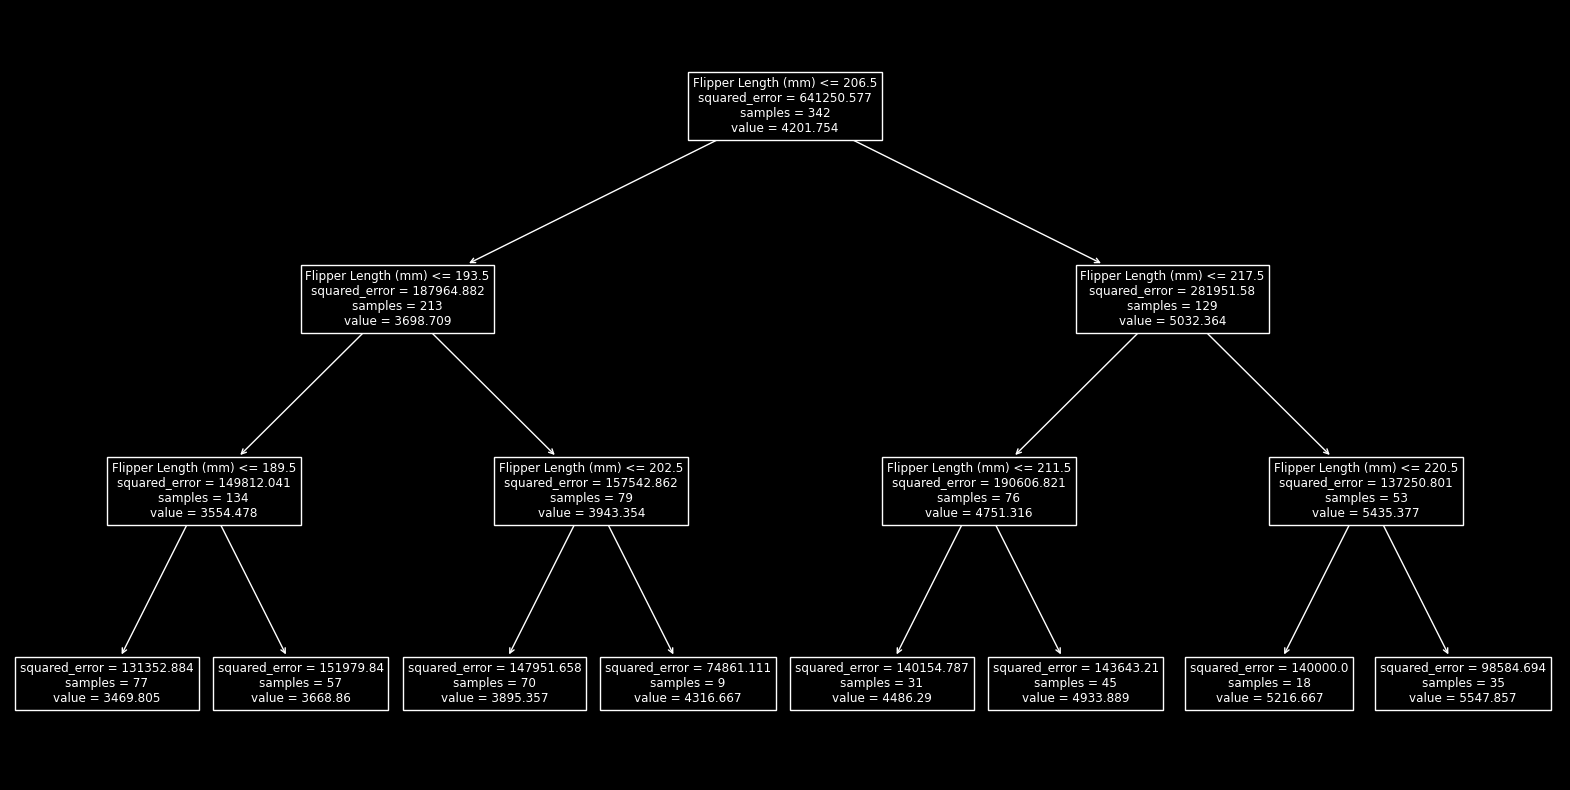

In [11]:
%matplotlib inline
_, ax = plt.subplots(figsize=(20, 10))
_ = plot_tree(tree, feature_names=[feature_name], ax=ax)

Of course, increasing the depth of the tree increases the risk of overfitting.
Let's look at a tree of depth 30.

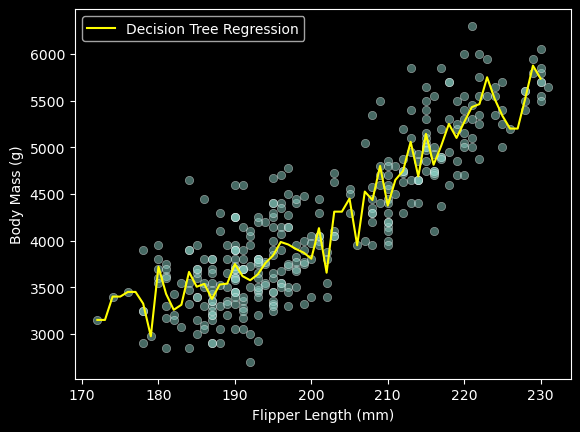

In [12]:
tree = DecisionTreeRegressor(max_depth=30)
tree.fit(data_train, target_train)
target_predicted = tree.predict(data_test)

sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, alpha=0.5
)
plt.plot(data_test[feature_name], target_predicted, color="yellow", 
         label= "Decision Tree Regression")
_ = plt.legend()

Finally to mention a major disadvantage of decision trees (and tree based models) is that they are not able to *extrapolate* from given data.
Concretely this means that a decision tree will not be able to predict a datapoint beyond the minimum and maximum values of our dataset.

## Hyperparameters

We discuss some hyperparameters of decision trees.
To this end, we created some helper functions to help with plotting.
You can find the python file on grips and to import it you'll need the following code.

In [13]:
import sys 
import os
sys.path.append(os.path.abspath("/Documents/ML2023/Ex231123"))

from convenience import fit_and_plot_classification
from convenience import fit_and_plot_regression

Above we have discussed the hyperparameter `max_depth`, i.e. the maximal depth of a decision tree.
Clearly, the larger a tree grows, the more prone we are to overfitting.
Thus to avoid overfitting and find the optimal depth of a decision tree for generalization, we will perform hyperparameter tuning.
Since we are only tuning one parameter here, we will use a gridsearch for hyperparameter tuning.

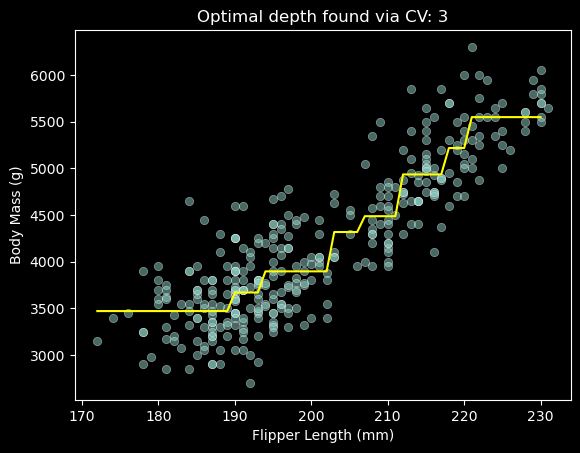

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth" : np.arange(2,10,1)}
tree_regr = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid)

fit_and_plot_regression(tree_regr, penguins, [feature_name], target_name)
_ = plt.title(
    f"Optimal depth found via CV: {tree_regr.best_params_['max_depth']}"
)

Here, `GridSearchCV` fits a model for each depth and evaluates it using cross-validation.

The `max_depth` parameter controls the overall complexity of the decision tree.
Notice however that the tree is built symmetrically if we just control the maximum depth.
But there is no reason why a tree should be symmetrical and in fact generalization performance could increase by growing some branches deeper than others.
We illustrate this using a classification tree and an artificial dataset.

In [20]:
from sklearn.datasets import make_blobs

data_clf_columns = ["Feature #0", "Feature #1"]
target_clf_column = "Class"

# Blobs that are interlaced
X_1, y_1 = make_blobs(
    n_samples=300, centers=[[0, 0], [-1, -1]], random_state=0
)
# Blobs that can be easily separated
X_2, y_2 = make_blobs(n_samples=300, centers=[[3, 6], [7, 0]], random_state=0)

X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2])
data_clf = np.concatenate([X, y[:, np.newaxis]], axis=1)
data_clf = pd.DataFrame(
    data_clf, columns=data_clf_columns + [target_clf_column]
)
data_clf[target_clf_column] = data_clf[target_clf_column].astype(np.int32)


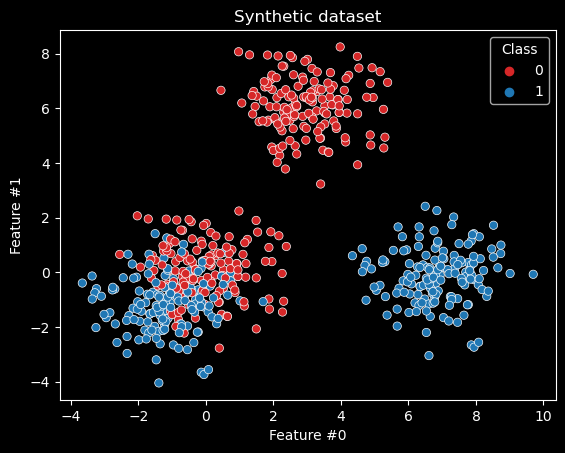

In [21]:
sns.scatterplot(
    data=data_clf,
    x=data_clf_columns[0],
    y=data_clf_columns[1],
    hue=target_clf_column,
    palette=["tab:red", "tab:blue"],
)
_ = plt.title("Synthetic dataset")

As you can see, there are two subsets.
One subset which is clearly seperated and one mixed one.
It implies that a decision tree will need more than one split to classify properly.

We first grow a tree of depth 2.
We expect it to be able to seperate points which are easy to seperate.

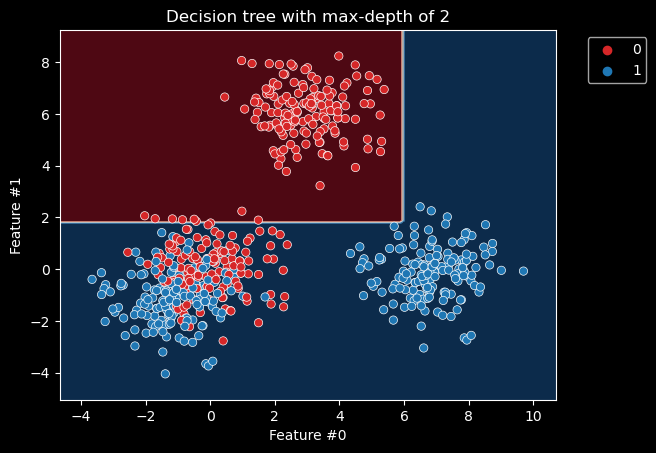

In [22]:
from sklearn.tree import DecisionTreeClassifier

max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

So, clearly more splits are needed to seperate the mixed datapoints.

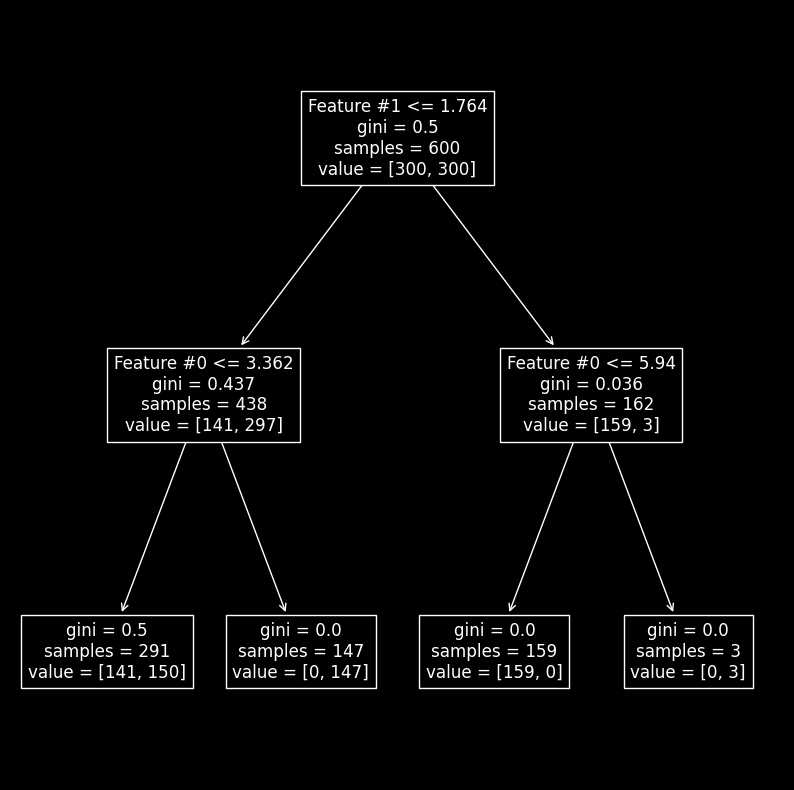

In [23]:
_, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

Here, the gini index measures inequality and is similar to entropy.
An index of 0 implies that the samples are homogenuous.

Now let's increase the depth.

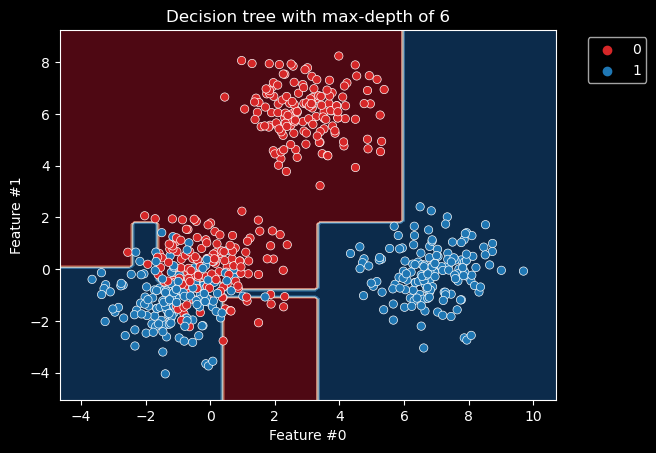

In [24]:
max_depth = 6
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

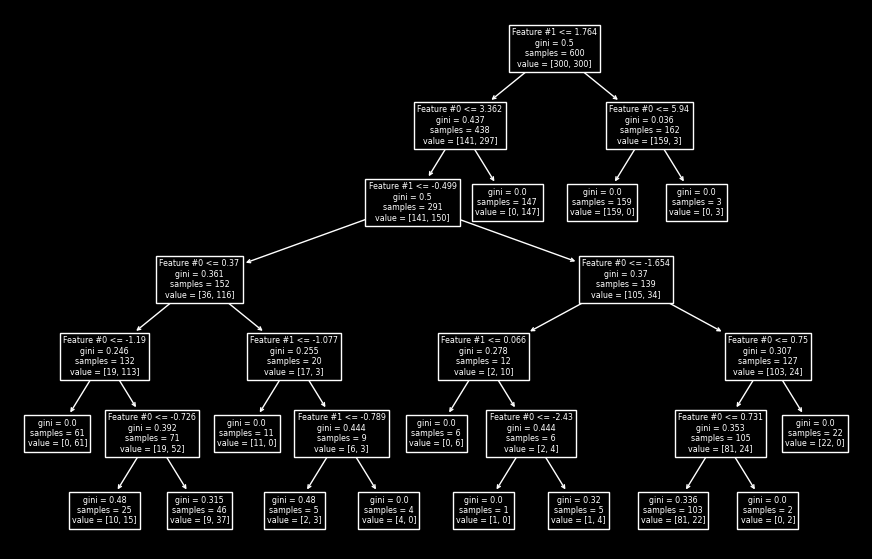

In [25]:
_, ax = plt.subplots(figsize=(11, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

As expected, the left branch continues to grow while the right branch does not split further.
Fixing the `max_depth` would cut the tree horizontally whether or not it would be beneficial to grow a branch further.

Decision trees have further hyperparameters:

* `min_samples_leaf` : This fixes the minimum samples each leaf has to have.
* `min_samples_split` : This fixes the minimum samples needed in each branch to perform a split. 
* `max_leaf_nodes` : This fixes the maximum number of leaves.
* `min_impurity_decrease` : ?

We will look at the parameter `min_samples_leaf`.

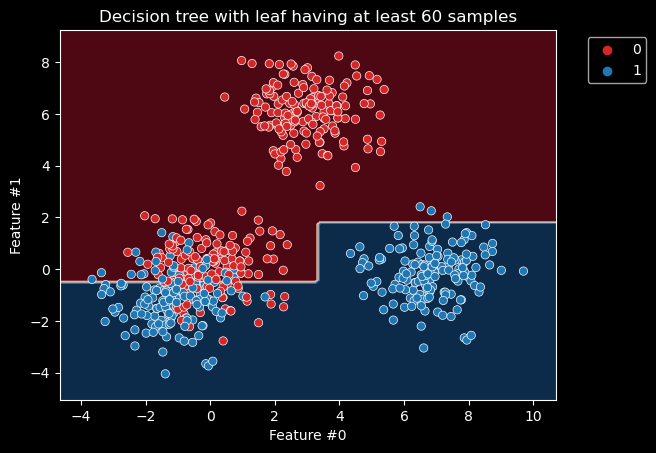

In [26]:
min_samples_leaf = 60
tree_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(
    f"Decision tree with leaf having at least {min_samples_leaf} samples"
)



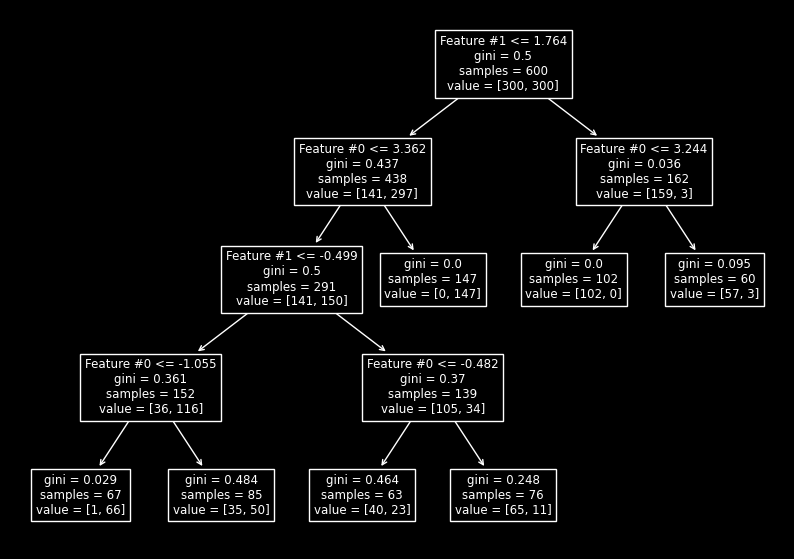

In [27]:
_, ax = plt.subplots(figsize=(10, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

As you can see, we obtain an asymmetrical tree.

# Ensembles

A comment on ensemble models.
In a sense this is similar to Alison's model for the california housing competition.
The idea is to combine several models into one.

What Alison used is called **Stacking**.
There is a function implemented in `scikit-learn` and maybe we will look at this next time.

In the competition the best models were *Random Forests* and *Gradient-boosting decision trees*.
These are based on two ways to combine models:
* Bagging (**B**ootstrap **Agg**regat**ing**)
* Boosting

For Bagging, several models are trained on random subsets of the training set and the results are then combined. An example is a **Random Forest**, where we grow deep (overfitted) trees on random subsets and combine them to avoid overfitting.

For Boosting, we combine several *weak* learners.
There are different kinds of Boosting.
The Gradient-boosting decision trees are based on gradient boosting, which is roughly speaking gradient descend on the space of functions.
In case of decision trees, this means growing shallow trees and performing gradient descent on them.